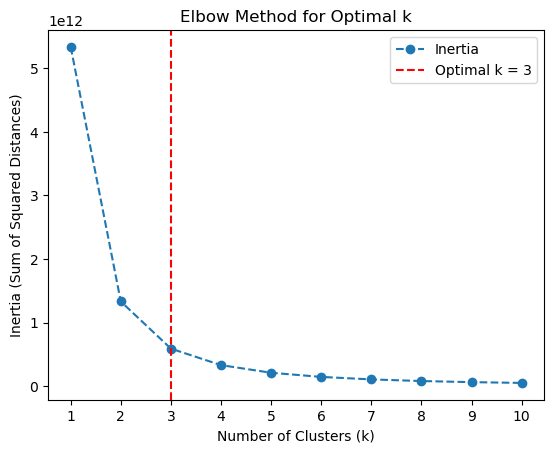

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


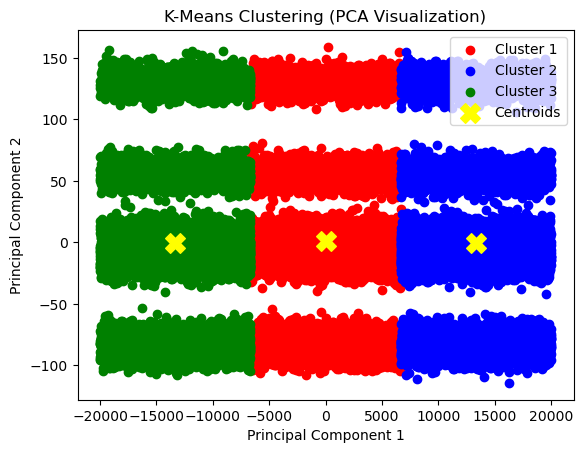

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv("unsupervised_data.csv")  # Replace with your file path

# Ensure the dataset contains only the features you want to cluster
features = data.select_dtypes(include=[np.number]).columns.tolist()
data = data[features].to_numpy()

# Function to calculate inertia (sum of squared distances to the nearest centroid)
def calculate_inertia(data, centroids, cluster_labels):
    inertia = 0
    for i, centroid in enumerate(centroids):
        cluster_data = data[cluster_labels == i]
        inertia += np.sum((cluster_data - centroid) ** 2)
    return inertia

# Function to perform K-Means
def kmeans(data, k, max_iterations=100, tolerance=1e-4):
    # Initialize centroids randomly
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    for _ in range(max_iterations):
        # Assign each data point to the nearest centroid
        distances = np.array([np.linalg.norm(data - centroid, axis=1) for centroid in centroids]).T
        cluster_labels = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array([data[cluster_labels == i].mean(axis=0) for i in range(k)])
        
        # Check for convergence
        if np.all(np.abs(new_centroids - centroids) < tolerance):
            break

        centroids = new_centroids

    # Calculate inertia
    inertia = calculate_inertia(data, centroids, cluster_labels)
    return centroids, cluster_labels, inertia

# Perform the elbow method
k_values = range(1, 11)  # Test k from 1 to 10
inertias = []

for k in k_values:
    _, _, inertia = kmeans(data, k)
    inertias.append(inertia)

# Find the optimal k using the elbow method
def find_elbow_point(k_values, inertias):
    x1, y1 = k_values[0], inertias[0]
    x2, y2 = k_values[-1], inertias[-1]

    distances = []
    for i in range(len(k_values)):
        x0, y0 = k_values[i], inertias[i]
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
        distances.append(numerator / denominator)

    return k_values[np.argmax(distances)]

optimal_k = find_elbow_point(k_values, inertias)

# Plot the elbow curve
plt.figure()
plt.plot(k_values, inertias, marker='o', linestyle='--', label="Inertia")
plt.axvline(x=optimal_k, color="red", linestyle="--", label=f"Optimal k = {optimal_k}")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values)
plt.legend()
plt.show()

# Perform K-Means with the optimal k
centroids, cluster_labels, _ = kmeans(data, optimal_k)

# Add cluster labels to the dataset for PCA visualization
data_with_clusters = pd.DataFrame(data, columns=features)
data_with_clusters["Cluster"] = cluster_labels

# Function to perform PCA
def pca(data, n_components):
    # Standardize the data
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    
    # Calculate the covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)
    
    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select the top n_components eigenvectors
    components = sorted_eigenvectors[:, :n_components]
    
    # Transform the data
    transformed_data = np.dot(centered_data, components)
    return transformed_data

# PCA for visualization
pca_data = pca(data, n_components=2)

# Visualize the clusters in PCA-transformed space
colors = ["red", "blue", "green", "purple", "orange", "cyan", "magenta"]  # Extend for more clusters if needed
plt.figure()
for i in range(optimal_k):
    cluster_data = pca_data[cluster_labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=colors[i], label=f"Cluster {i+1}")

# Transform and plot centroids in PCA space
pca_centroids = pca(centroids, n_components=2)
plt.scatter(pca_centroids[:, 0], pca_centroids[:, 1], c="yellow", marker="X", s=200, label="Centroids")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.title("K-Means Clustering (PCA Visualization)")
plt.show()
